In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch .utils.data import  DataLoader
from torchvision.transforms import ToTensor,Resize, Normalize
from torchvision import transforms
import os
import matplotlib.pyplot as plt


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
root_dir = "/content/drive/MyDrive/hymenoptera_data"
os.listdir(root_dir)

['train', 'val']

In [25]:
transforms = transforms.Compose([Resize((224,224)),
                                 ToTensor(),
                                 Normalize([0.485, 0.456,0.406], [0.229, 0.224, 0.225])])

In [26]:
train_data = ImageFolder(root = os.path.join(root_dir, 'train'),
                         transform = transforms)

In [27]:
idx_to_class = {j:i for i, j in train_data.class_to_idx.items()}

Text(0.5, 1.0, 'ants')

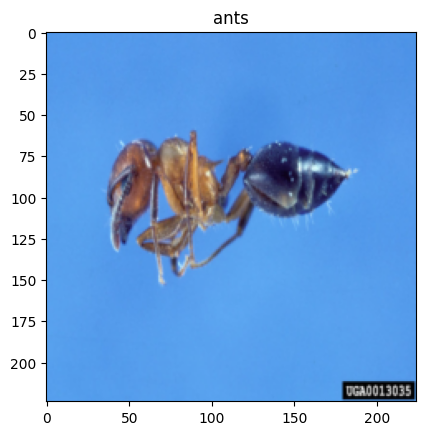

In [28]:
sample_img = train_data[0][0].numpy().transpose(1,2,0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * sample_img + mean
inp = np.clip(inp,0,1)
plt.imshow(inp)
plt.title(idx_to_class[(train_data[0][1])])

In [29]:
train_data = ImageFolder(root= os.path.join(root_dir, 'train'),
                         transform=transforms)

val_data = ImageFolder(root = os.path.join(root_dir,'val'),
                       transform = transforms)

In [30]:
train_dataloader = DataLoader(train_data, batch_size = 50, shuffle=True, num_workers = 0)
test_dataloader = DataLoader(val_data, batch_size = 50, shuffle=True, num_workers = 0)

In [31]:
class block(nn.Module):
    def __init__(self, in_channels, intermidate_channels, identity_downsample = None, stride = 1):
        super().__init__()
        self.expantion = 4
        self.conv1 = nn.Conv2d(in_channels,intermidate_channels, kernel_size = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(intermidate_channels)
        self.conv2 = nn.Conv2d(intermidate_channels,intermidate_channels,kernel_size=3, stride = stride, padding = 1, bias = False )
        self.bn2 = nn.BatchNorm2d(intermidate_channels)
        self.conv3 = nn.Conv2d(intermidate_channels, intermidate_channels*4, kernel_size = 1, bias = False )
        self.bn3 = nn.BatchNorm2d(intermidate_channels*4)
        self.identity_downsample = identity_downsample
        self.stride = stride


    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x = x + identity
        x = F.relu(x)
        return x





In [32]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels,self.in_channels, kernel_size = 7, stride=2, padding= 3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)

        self.layer1 = self._make_layer(block, layers[0], 64, 1)
        self.layer2 = self._make_layer(block, layers[1], 128, 2)
        self.layer3 = self._make_layer(block, layers[2], 256, 2)
        self.layer4 = self._make_layer(block, layers[3], 512, 2)

        self.fc1 = nn.Linear(512*4, num_classes)

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding =1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x,(1,1))
        x = x.flatten(1)
        x = self.fc1(x)
        return x


    def _make_layer(self, block, num_residual_blocks, intermidate_channels, stride):
        identity_downsample= None
        layers = []

        if stride != 1 or self.in_channels != (intermidate_channels*4):
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, intermidate_channels*4, stride=stride, kernel_size= 1, bias = False),
                nn.BatchNorm2d(intermidate_channels *4)
            )

        layers.append(
            block(self.in_channels,intermidate_channels, identity_downsample, stride)
            )

        self.in_channels = intermidate_channels *4

        for i in range(num_residual_blocks -1):
            layers.append(block(self.in_channels, intermidate_channels))

        return nn.Sequential(*layers)


In [33]:
def ResNet50(img_channel = 3, num_classes = 1000):
    return ResNet(block, [3,4,6,3], img_channel, num_classes)

def ResNet101(img_channel = 3, num_classes = 1000):
    return ResNet(block, [3,4,23,3], img_channel, num_classes)

def ResNet152(img_channel = 3, num_classes = 1000):
    return ResNet(block, [3,8,36,3], img_channel, num_classes)



In [34]:
def weights_init(layer_in):
    if isinstance(layer_in, nn.Linear):
        nn.init.kaiming_uniform_(layer_in.weight)
        layer_in.bias.data.fill_(0.0)

In [35]:
model = ResNet50().to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


In [36]:
def train(epoch, dataloader):
    model.train()
    torch.autograd.set_detect_anomaly(True)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # Store resultsn   n
        if batch_idx % 3 == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_data), loss.item()))

In [37]:
def test(dataloader, predictions = None):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        if predictions == None:
            for data, target in dataloader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.data.max(1, keepdim=True)[1]
                test_loss += criterion(output, target).item()
                correct += pred.eq(target.data.view_as(pred)).sum()
        else:
            for data in dataloader:
                data = data.to(device)
                output = model(data)
                pred = output.data.max(1, keepdim=True)[1]
                predictions.append(pred)

    test_loss /= len(test_dataloader.dataset)
    if predictions == None:
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(dataloader.dataset),
            100. * correct / len(dataloader.dataset)))

In [38]:

n_epochs = 35
for epoch in range(1, n_epochs + 1):
  train(epoch, train_dataloader)
  # testing on the same data to get more info in the model
  test(test_dataloader)


Train Epoch: 1 [0/244]	Loss: 10.375289
Train Epoch: 1 [150/244]	Loss: 2.799236

Test set: Avg. loss: 362538395.6078, Accuracy: 83/153 (54%)

Train Epoch: 2 [0/244]	Loss: 3.181585
Train Epoch: 2 [150/244]	Loss: 1.602948

Test set: Avg. loss: 131378.4551, Accuracy: 83/153 (54%)

Train Epoch: 3 [0/244]	Loss: 1.669810
Train Epoch: 3 [150/244]	Loss: 2.439615

Test set: Avg. loss: 1387.0975, Accuracy: 84/153 (55%)

Train Epoch: 4 [0/244]	Loss: 0.706779
Train Epoch: 4 [150/244]	Loss: 0.759935

Test set: Avg. loss: 23.6309, Accuracy: 86/153 (56%)

Train Epoch: 5 [0/244]	Loss: 0.604609
Train Epoch: 5 [150/244]	Loss: 0.628428

Test set: Avg. loss: 11.0325, Accuracy: 83/153 (54%)

Train Epoch: 6 [0/244]	Loss: 0.784453
Train Epoch: 6 [150/244]	Loss: 3.424913

Test set: Avg. loss: 8.5358, Accuracy: 91/153 (59%)

Train Epoch: 7 [0/244]	Loss: 0.903413
Train Epoch: 7 [150/244]	Loss: 0.997310

Test set: Avg. loss: 1.6378, Accuracy: 70/153 (46%)

Train Epoch: 8 [0/244]	Loss: 1.138146
Train Epoch: 8 [150

In [39]:
test(test_dataloader)


Test set: Avg. loss: 0.0148, Accuracy: 103/153 (67%)

